# ResNet 152

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import BertModel, BertTokenizer
from PIL import Image
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/matt/miniconda3/envs/exist2025/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
torch.cuda.is_available()

False

In [3]:
# This is the path for testing on my local machine
base_path = '../../../../dat/EXIST 2025 Memes Dataset/training/'

# This is the path for running on the PACE Cluster
#base_path = '/storage/coda1/p-dsgt_clef2025/0/shared/exist/latest/EXIST 2025 Memes Dataset/training/'

file_name = 'EXIST2025_training.json'

#print("path:", train_path)
image_path_col = 'path_memes'
target_col = 'labels_task2_1'

In [4]:
class ImageDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #print("path:", base_path + self.df.loc[idx, image_path_col])
        image = Image.open(base_path + self.df.loc[idx, image_path_col]).convert('RGB')
        label = self.df.loc[idx, target_col]
        #print("label:", label)
        return self.transform(image), torch.tensor(label, dtype=torch.long)

In [5]:
def convert_and_aggregate(label_list):
    binary = [1 if label == "YES" else 0 for label in label_list]
    return Counter(binary).most_common(1)[0][0]

In [6]:


data_df = pd.read_json(base_path+file_name).T[[image_path_col, target_col]]
X = data_df.drop(target_col, axis=1)
y = data_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
train_df[target_col] = train_df[target_col].apply(convert_and_aggregate)
test_df[target_col] = test_df[target_col].apply(convert_and_aggregate)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageDataset(train_df, transform)
test_dataset = ImageDataset(test_df, transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [7]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, bottleneck_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)

        self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)

        self.conv3 = nn.Conv2d(bottleneck_channels, bottleneck_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(bottleneck_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=2):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, bottleneck_channels, blocks, stride=1):
        downsample = None
        out_channels = bottleneck_channels * block.expansion

        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = [block(self.in_channels, bottleneck_channels, stride, downsample)]
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, bottleneck_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [9]:
def resnet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


In [10]:
model = resnet152()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
epochs = 3
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item())

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1:  68%|█████████████████████████████████████████████████▉                       | 277/405 [06:05<02:54,  1.36s/it, loss=0.716]/home/matt/miniconda3/envs/exist2025/lib/python3.11/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████| 405/405 [08:54<00:00,  1.32s/it, loss=0.661]


Epoch 1 - Loss: 0.7156, Accuracy: 0.5496


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████| 405/405 [08:57<00:00,  1.33s/it, loss=0.592]


Epoch 2 - Loss: 0.6985, Accuracy: 0.5586


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████| 405/405 [09:03<00:00,  1.34s/it, loss=0.56]

Epoch 3 - Loss: 0.6962, Accuracy: 0.5546


In [11]:
model.eval()
test_preds, test_targets = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(labels.numpy())

acc = accuracy_score(test_targets, test_preds)
print(f"Test Accuracy: {acc:.4f}")


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████| 102/102 [00:43<00:00,  2.37it/s]

Test Accuracy: 0.5649


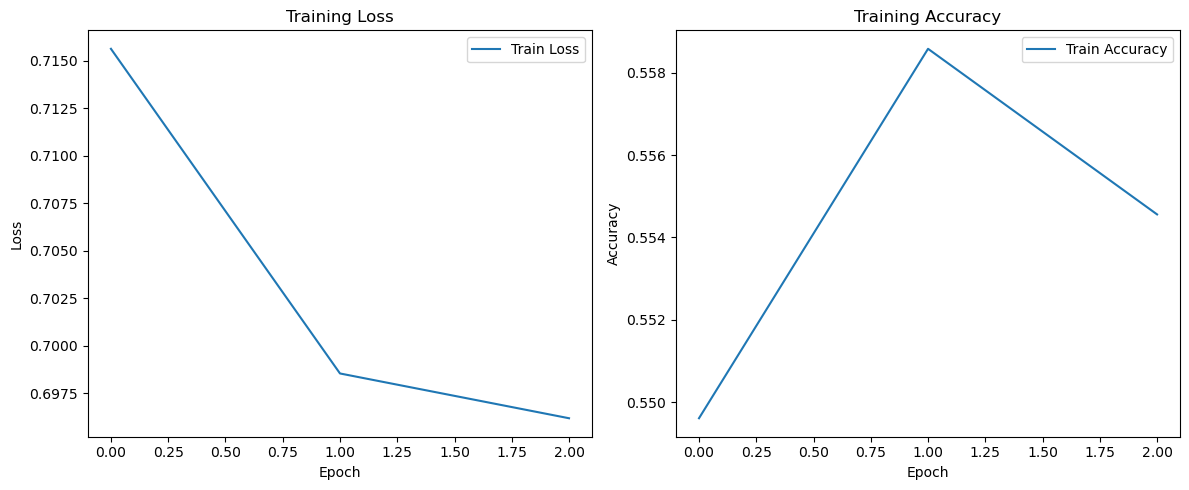

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()